# Проект: Анализ бизнес-показателей

**Проведем маркетинговый анализ приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.**

**Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:**<br>
-лог сервера с данными об их посещениях,<br>
-выгрузка их покупок за этот период,<br>
-рекламные расходы.<br>
**Нам предстоит изучить:**<br>
-откуда приходят пользователи и какими устройствами они пользуются,<br>
-сколько стоит привлечение пользователей из различных рекламных каналов;<br>
-сколько денег приносит каждый клиент,<br>
-когда расходы на привлечение клиента окупаются,<br>
-какие факторы мешают привлечению клиентов.

**Предстоит пройти 6 шагов:** <br>
Шаг 1. Загрузим данные и подготовим их к анализу.<br>
Шаг 2. Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.<br>
Шаг 3. Исследовательский анализ данных.<br>
Шаг 4. Маркетинг.<br>
Шаг 5. Оценим окупаемость рекламы.<br>
Шаг 6. Сделаем выводы

### Загрузите данные и подготовьте их к анализу

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, poisson, norm
from scipy import stats as st
import math
from math import factorial
from math import sqrt
import time
from datetime import datetime
from datetime import datetime, timedelta

<i>Пропусков в данных нет, неверные типа в столбцах `Session Start`, `Session End`. Некорректные названия столбцов.<i>

<i>Пропусков в данных нет, неверные типа в столбцах `Event Dt`. Некорректные названия столбцов.<i>

<i>Пропусков в данных нет, неверные типа в столбцах `dt`. Некорректные названия столбцов.<i>

**Исправим названия столбцов в каждом DataFrame. Поменяем тип для дат.**

In [5]:
#данные о визитах:
visits.rename(columns = {
    'User Id':'user_id', 
    'Region':'region', 
    'Device':'device', 
    'Channel':'channel', 
    'Session Start':'session_start', 
    'Session End':'session_end'},
              inplace = True )
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

visits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [6]:
#данные о заказах:
orders.rename(columns = {
    'User Id':'user_id', 
    'Event Dt':'event_dt', 
    'Revenue':'revenue'},
              inplace = True )
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [7]:
#данные о расходах:
costs.rename(columns = {
    'Channel':'channel'},
              inplace = True )
costs['dt'] = pd.to_datetime(costs['dt'])

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


<i>Названия столбцов переименованы, изменены типы столбцов с датами.<i>

**Проверим данные на дубликаты:**

In [8]:
visits.duplicated().sum() 

0

In [9]:
orders.duplicated().sum() 

0

In [10]:
costs.duplicated().sum() 

0

<i>Явных дубликатов нет.<i>

**Вывод: при прочтении датасетов было обнаружено и исправлено:<br>**
-неверные типы в столбцах с датами<br>
-некорректные названия столбцов.<br>
**Явных дубликатов не обнаружено, пропусков в данных нет.**

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [11]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [12]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


In [13]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
def get_ltv(
    profiles,  # Шаг 1. Получить профили и данные о покупках
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Добавить данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 3. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Шаг 4. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 5. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 6. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 7. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [15]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [16]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


In [17]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()


In [18]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

**Определим минимальную и максимальную даты привлечения пользователей:**

In [19]:
profiles = get_profiles(visits, orders, costs)

In [20]:
print('Минимальная дата привлечения пользователей: ', profiles['first_ts'].min())

Минимальная дата привлечения пользователей:  2019-05-01 00:00:41


In [21]:
print('Максимальная дата привлечения пользователей: ', profiles['first_ts'].max())

Максимальная дата привлечения пользователей:  2019-10-27 23:59:04


<i> Максимальная и минимальная даты привлечения соотвествуют входным данным в начале проекта: "Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:".<i>

**Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постром таблицу, отражающую количество пользователей и долю платящих из каждой страны.**

In [22]:
def analysis_profiles(cohort):
    profiles = get_profiles(visits, orders, costs)
    if cohort == 'region' or  cohort == 'device':
    #Функция для составления таблицы кагорты и построенния круговой диаграммы
        
        display(profiles.groupby(cohort).agg({'user_id':'nunique','payer': 'mean'}).sort_values(by = 'payer', ascending = False).style.format({'payer': "{:.2%}"}))
        profiles.groupby(cohort).agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False).plot( kind='pie', y='user_id', autopct='%1.0f%%', legend=False)
        if cohort == 'region':
            plt.ylabel("Уникальные пользователи ")
            plt.title("Соотношение пользователей из разных регионов")
        elif cohort == 'region':
            plt.ylabel("Уникальные пользователи ")
            plt.title("Соотношение девайсов")
    elif cohort == 'channel':
        display(profiles.groupby(cohort).agg({'user_id':'nunique','payer': 'mean'}).sort_values(by = 'payer', ascending = False).style.format({'payer': "{:.2%}"}))
        profiles.groupby(cohort).agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = True).plot(kind='barh', figsize=(3,3))
        plt.xlabel("Медианное значение проданных копий в млн.")
        plt.ylabel("Названия жанров")
        plt.title("Распределение игр по жанрам")

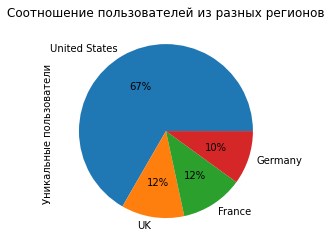

In [23]:
analysis_profiles('region')

<i>Большая часть пользователей (совершавших покупки и нет) из США. Франция, Англии и Германия занимают лишь около 10-12% от общего кол-ва уникальных пользователей. Почти 7% платящих пользователей также из США. А вот в Германии хоть и пользователей меньше, чем в Англии и Фрнации, но при это доля платящих выше. <i>

**Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.**

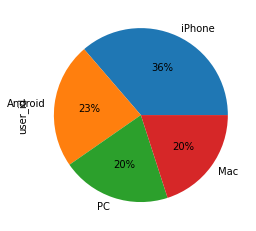

In [24]:
analysis_profiles('device')

<i>Большинство пользователей (совершавших покупки и нет) пользуются iphone, остальные почти в равной доли пользуются другими девайсами. Если же говорить о доле платящих пользователей, то здесь преобладает Mac c небольшим отрывом от iphone, но в целом разница небольшая между остальными девайсами. <i>

**Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.**

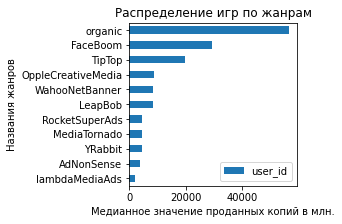

In [25]:
analysis_profiles('channel')

<i>Больше всего привлечение идет из органического канала, потом только из FaceBoom и TipTop. Больше всего платящих пользователей из каналов FaceBoom, AdNonSense, lambdaMediaAds.<i>

**Вывод шага 3: <br>
Портрет пользователя (в независимости платащий он или нет):<br>
-Пользователь из `United States`, с девайсом `iphone` привлеченный из канала `organic`.<br>
Портрет платящего пользователя:<br>
-Пользователь из `United States`, с девайсом `Mac` привлеченный из канала `Faceboom`.**


### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

**Посчитаем общую сумму расходов на маркетинг.**

In [26]:
total_sum = int(costs['costs'].sum())

**Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник:**

In [27]:
costs_chan = costs.groupby('channel').agg({'costs':'sum'}).sort_values('costs', ascending=False)
costs_chan['percent'] = (costs_chan['costs'] / total_sum) * 100
costs_chan['percent'] = costs_chan['percent'].round(2)
costs_chan

costs  percent
channel                              
TipTop              54751.30    51.90
FaceBoom            32445.60    30.75
WahooNetBanner       5151.00     4.88
AdNonSense           3911.25     3.71
OppleCreativeMedia   2151.25     2.04
RocketSuperAds       1833.00     1.74
LeapBob              1797.60     1.70
lambdaMediaAds       1557.60     1.48
MediaTornado          954.48     0.90
YRabbit               944.22     0.90

<i>Если сравнивать траты на каждый источник с общей суммой трат, можно сделать вывод, что половина от всего ушла на канал FaceBoom.<i>

**Постром график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику.**

Text(0.5, 1.0, 'Динамика изменения расходов во времени по неделям по каждому источнику')

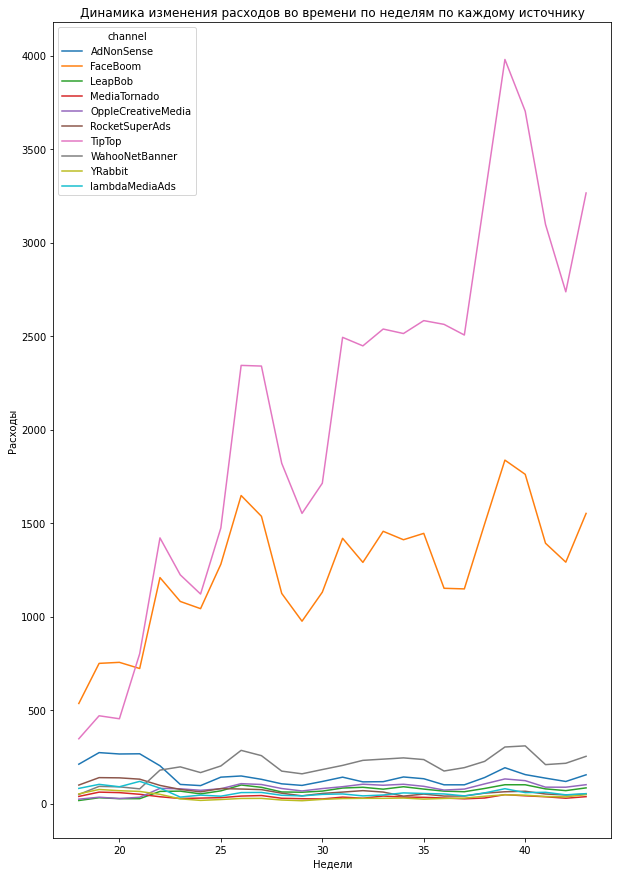

In [28]:
costs['week'] = costs['dt'].dt.isocalendar().week
costs.pivot_table(index = 'week', columns = 'channel', values='costs', aggfunc='sum').plot(figsize=(10,15))
plt.xlabel("Недели")
plt.ylabel("Расходы")
plt.title("Динамика изменения расходов во времени по неделям по каждому источнику")

**Постром график с визуализацией динамики изменения расходов во времени по месяцам по каждому источнику.**

Text(0.5, 1.0, 'Динамика изменения расходов во времени по месяцам по каждому источнику')

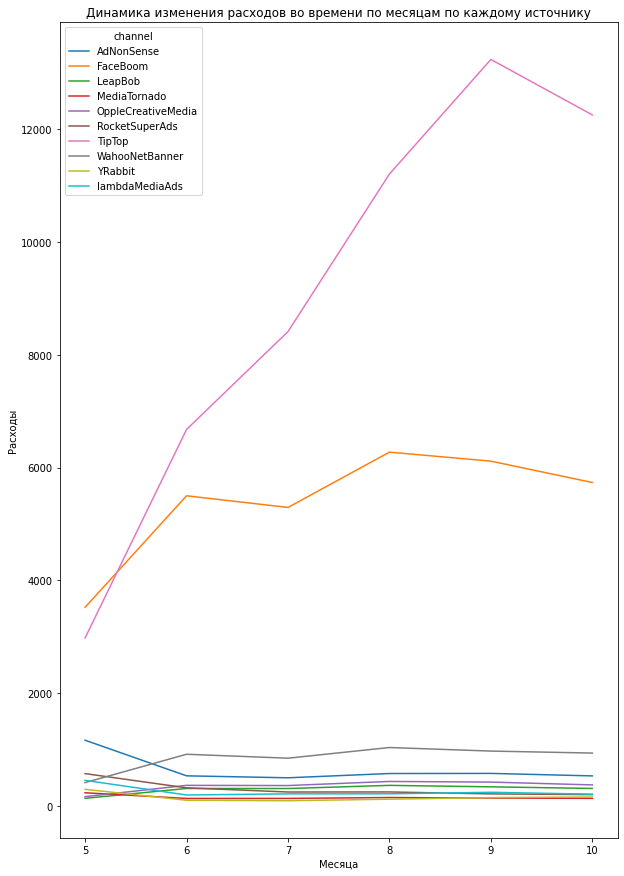

In [29]:
costs['month'] = costs['dt'].dt.month
costs.pivot_table(index = 'month', columns = 'channel', values='costs', aggfunc='sum').plot(figsize=(10,15))
plt.xlabel("Месяца")
plt.ylabel("Расходы")
plt.title("Динамика изменения расходов во времени по месяцам по каждому источнику")

<i>Везде скачущая динамика, но можно заметить, что TipTop и FaceBoom лидируют, по сравнению с остальными.<i>

**Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.**

In [30]:
profiles = get_profiles(visits, orders, costs)
profiles = profiles.query('channel != "organic"')
profiles = profiles.groupby('channel').agg({'user_id':'nunique', 'acquisition_cost': 'sum'})
profiles['cac'] = profiles['acquisition_cost'] / profiles['user_id']
profiles['cac'] = profiles['cac'].round(2)
profiles.sort_values('cac', ascending=False)

user_id  acquisition_cost   cac
channel                                            
TipTop                19561          54751.30  2.80
FaceBoom              29144          32445.60  1.11
AdNonSense             3880           3911.25  1.01
lambdaMediaAds         2149           1557.60  0.72
WahooNetBanner         8553           5151.00  0.60
RocketSuperAds         4448           1833.00  0.41
OppleCreativeMedia     8605           2151.25  0.25
MediaTornado           4364            954.48  0.22
YRabbit                4312            944.22  0.22
LeapBob                8553           1797.60  0.21

<i>Самые дорогостоящие пользователи пришли из канала `TipTop`.<i>

**Вывод шага 4:<br>
Общая сумма трат на рекламу составила чуть более 100 000.<br>
Самые дорогостоящие источники рекламы `TipTop`, `FaceBoom`<br>
Яркая динамика также наблюдается у двух этих каналов рекламы (`TipTop`, `FaceBoom`), что месяцам, что по неделям. <br>
Самый дорогие пользователи из канала `TipTop`.**

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

**Проанализируем окупаемость рекламы c помощью графиков LTV. и ROI, а также графики динамики LTV, CAC и ROI.**

In [31]:
observation_date = datetime(2019, 11, 1).date()
analysis_horizon = 14 
profiles = get_profiles(visits, orders, costs)
profiles = profiles.query('channel != "organic"')
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon
)

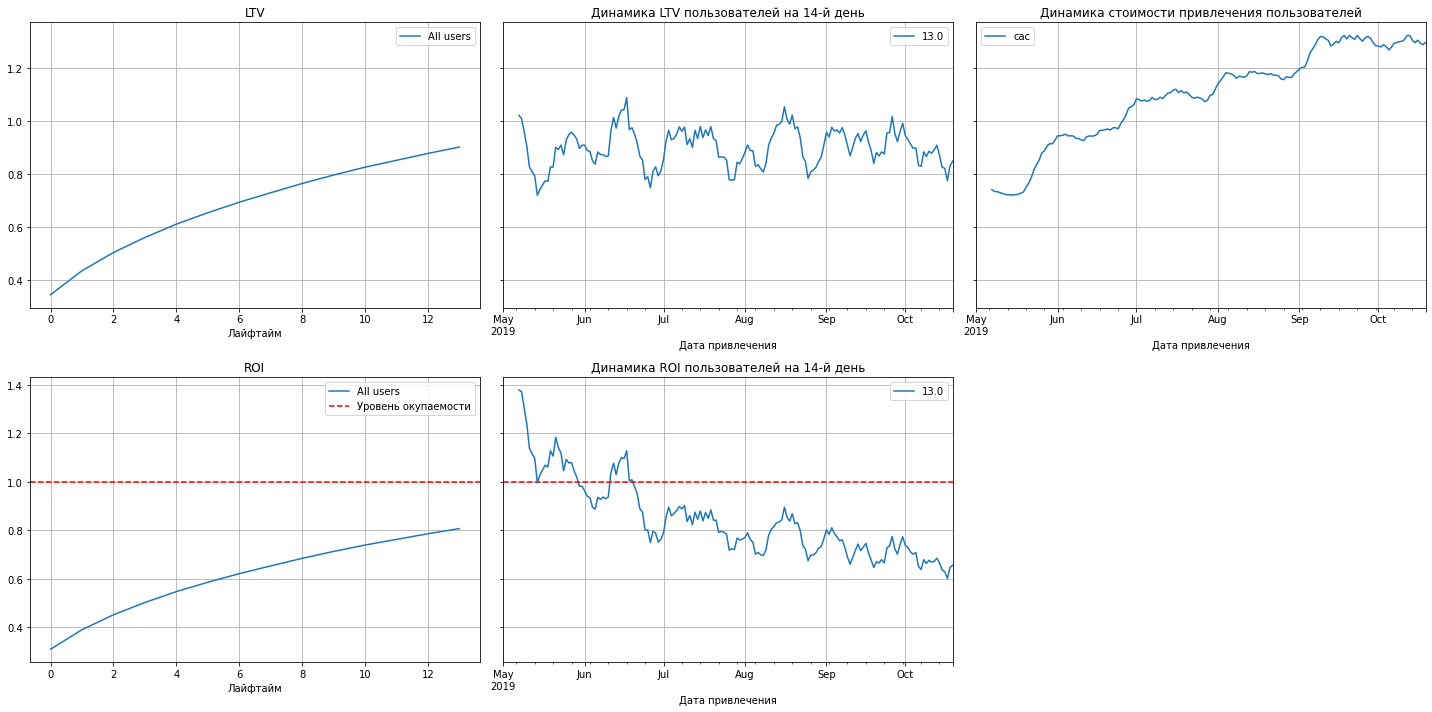

In [32]:
plot_ltv_roi(ltv,ltv_history, roi, roi_history, analysis_horizon, window=7 )

<i>Снижения LTV и ROI  на графиках нет, что говорит о корректном расчете данных. Аномалий нет - линии динамики показателей растут и падают синхронно.<i>

**Построим и изучим графики конверсии по устройствам**

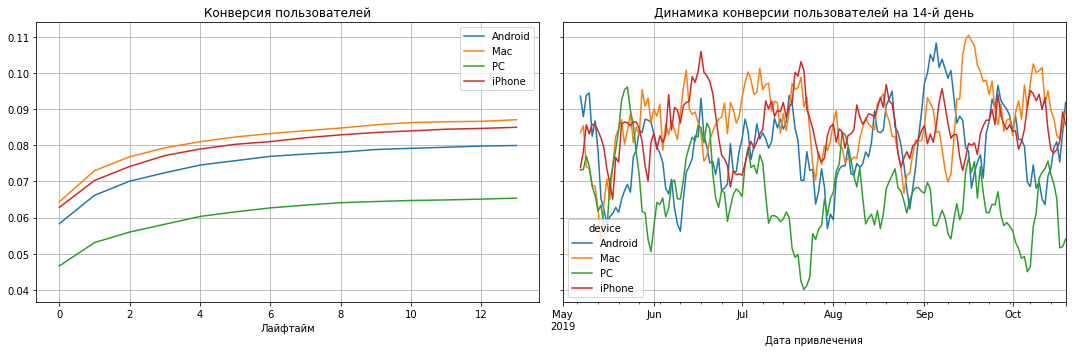

In [33]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions= ['device']
)

plot_conversion(conversion_grouped, conversion_history, analysis_horizon)

<i>Пользователи, которые пользуются Mac, приносят больше прибыли, чем остальные. На динамике конверсии на 14-й день заметить можно различные  скачки пользователей с разными девайсами, особенно выделяются Mac, Android, IPhone. <i>

**Построим и изучим графики удержания по устройствам**

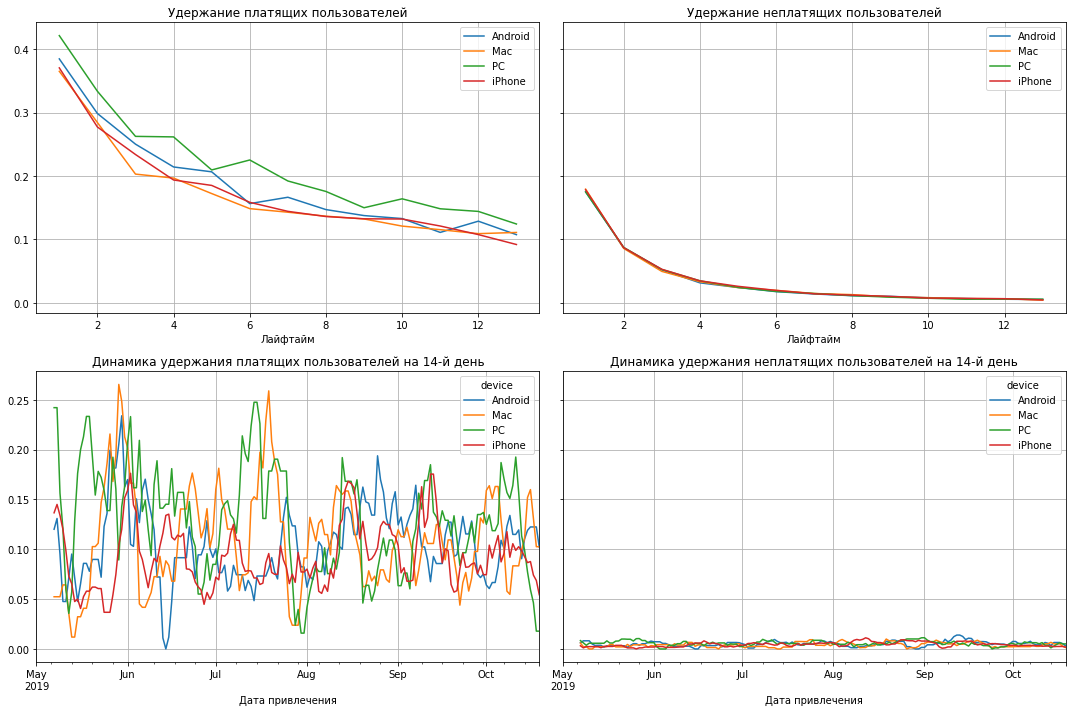

In [34]:
retention_raw, retention, retention_history = get_retention(profiles, visits, observation_date, analysis_horizon, dimensions=['device'])
# смотрим удержание с разбивкой по устройствам
plot_retention(retention, retention_history, analysis_horizon) 

<i>Удержание платящих пользователей намного выше, чем неплатящих. Если смотреть отдельно по гаджетам, больше удержание пользователей на PC.<i>

**Построим и изучим графики конверсии по странам**

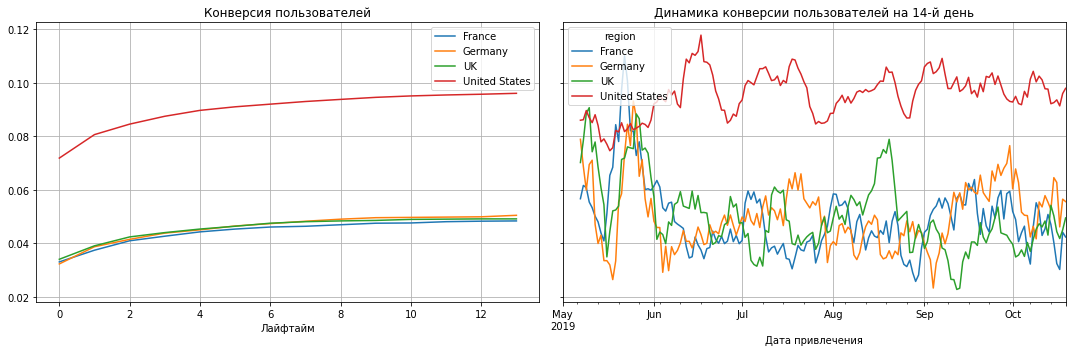

In [35]:

# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions= ['region']
)

plot_conversion(conversion_grouped, conversion_history, analysis_horizon)

<i>Пользователи, которые из США, приносят больше прибыли, чем остальные три страны, эти страны находятся на одном уровне. На динамике конверсии на 14-й день заметить можно различные скачки пользователей с разными девайсами, особенно выделются также пользователи из США.<i>

**Построим и изучим графики удержания по странам**

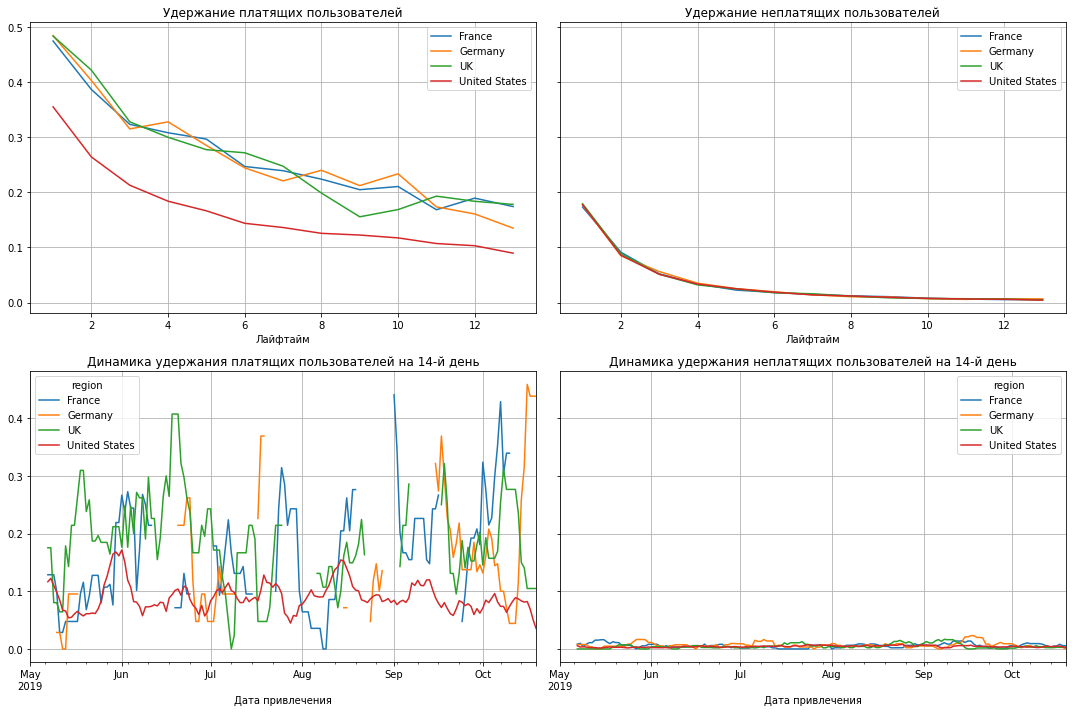

In [36]:
retention_raw, retention, retention_history = get_retention(profiles, visits, observation_date, analysis_horizon, dimensions=['region'])
# смотрим удержание с разбивкой по регионам
plot_retention(retention, retention_history, analysis_horizon) 

<i>Удержание платящих пользователей намного выше, чем неплатящих. Если смотреть отдельно по регионам, пользователи из США менее удержживаются, чем пользователи из других стран. На динамике удержания можно заметить обрывы во всех странах кроме США.  <i>

**Построим и изучим графики конверсии по каналам рекламы**

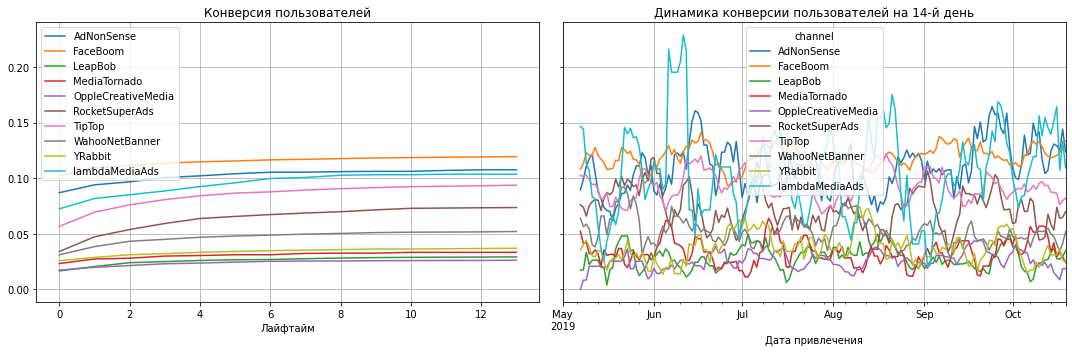

In [37]:

# смотрим конверсию с разбивкой по каналам рекламы

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions= ['channel']
)

plot_conversion(conversion_grouped, conversion_history, analysis_horizon)

<i>Больше прибыли приносят пользователи привлченные через FaceBoom. На динамике конверсии выделяется канал LambdeMediaAds.<i>

**Построим и изучим графики удержания по каналам рекламы**

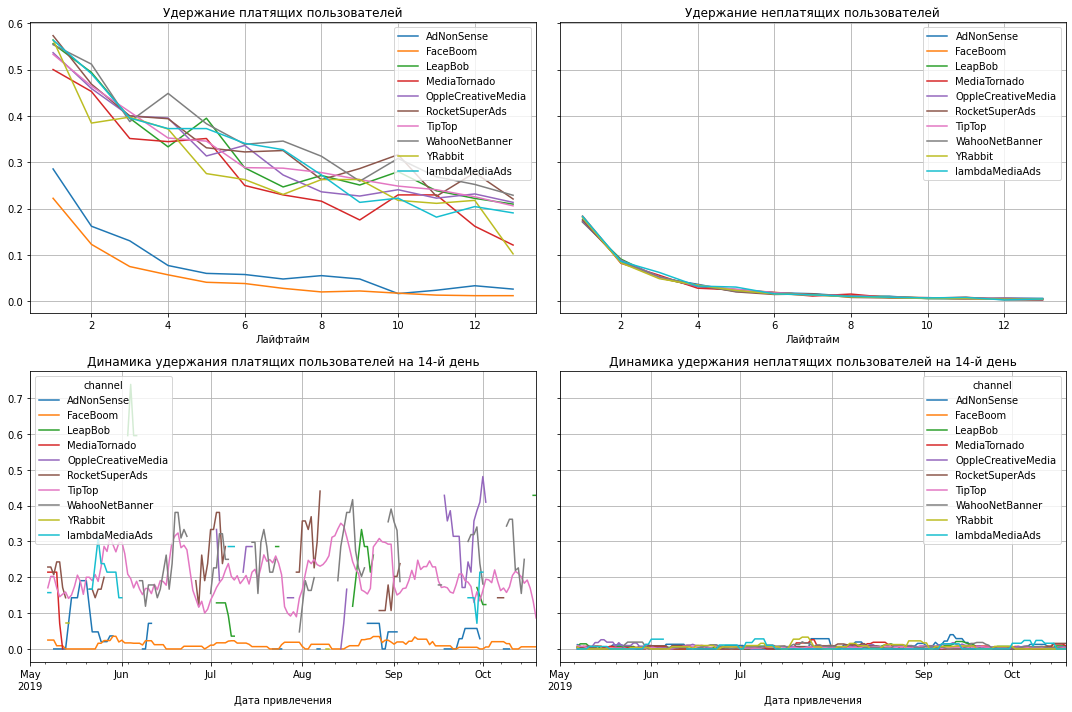

In [38]:
retention_raw, retention, retention_history = get_retention(profiles, visits, observation_date, analysis_horizon, dimensions=['channel'])
# смотрим удержание с разбивкой по каналам рекламы
plot_retention(retention, retention_history, analysis_horizon) 

<i>Удержание платящих пользователей намного выше, чем неплатящих. Если смотреть отдельно по каналам привлечения,  пользователи привлеченые через канал FaceBoom хуже все удерживаются, а также через канал AdNonSense.<i>

**Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**

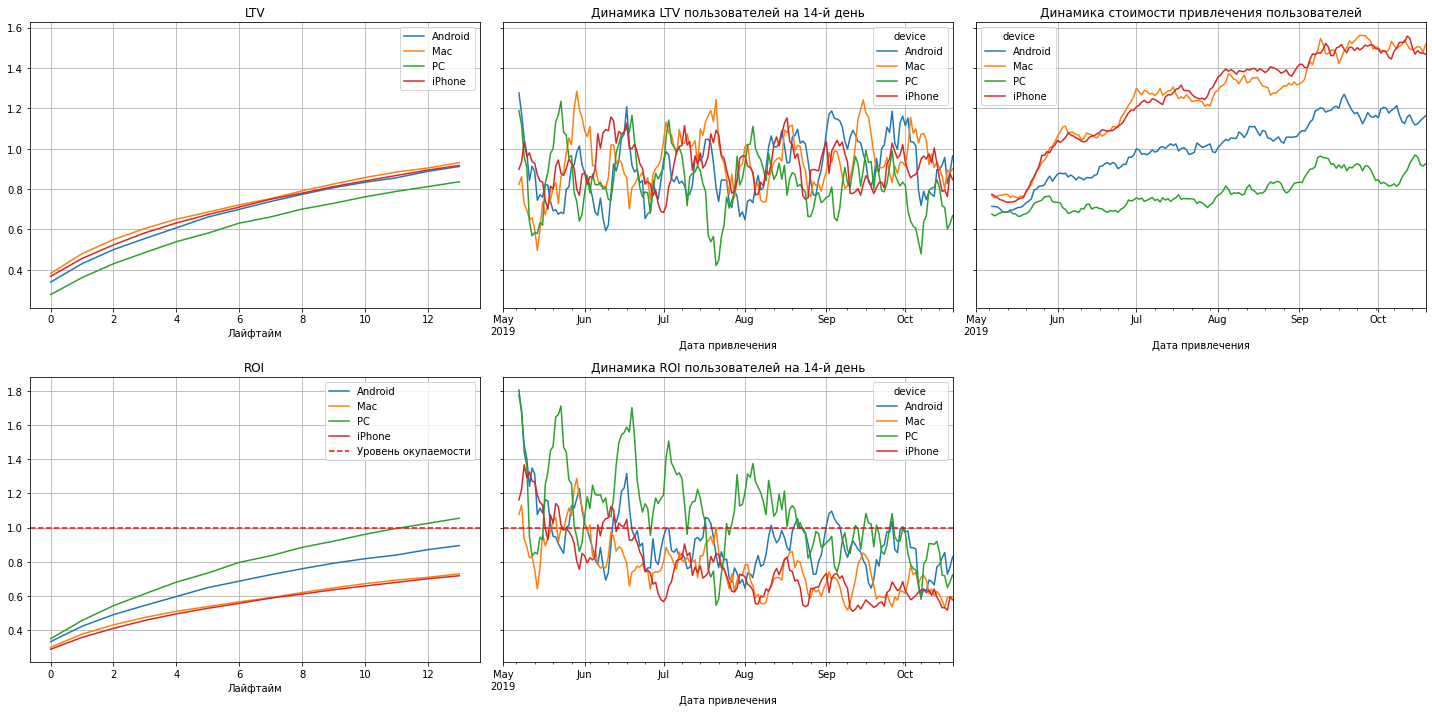

In [39]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=['device'])
plot_ltv_roi(ltv,ltv_history, roi, roi_history, analysis_horizon, window=7)

<i>Дороже всех привлечение пользователй с MAC и IPhone. Окупаются только пользоваетли с PC на 11 день. Менее окупаемые пользователи с MAC и IPhone. LTV у пользователей с PC ниже, чем у других трех.<i>


**Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**


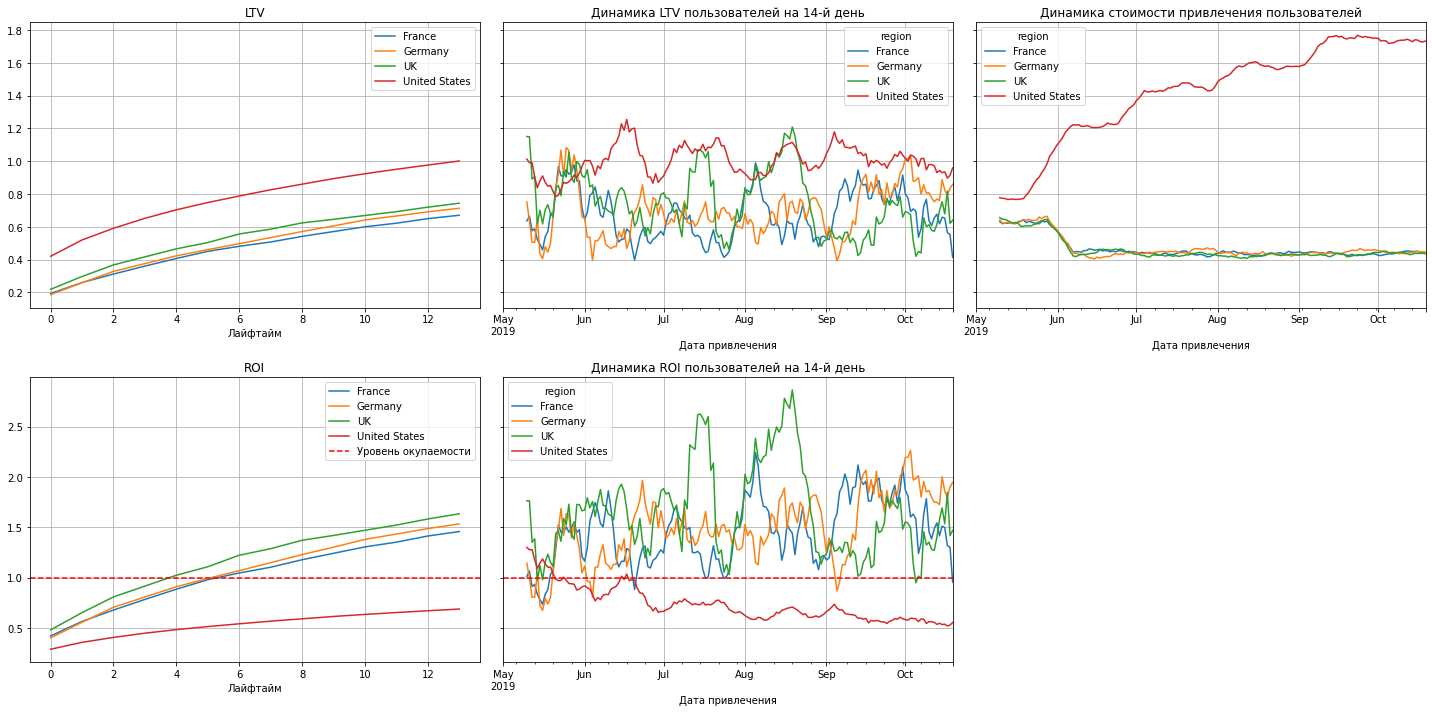

In [40]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=['region'])
plot_ltv_roi(ltv,ltv_history, roi, roi_history, analysis_horizon, window=10)

<i>Дороже всех привлечение пользователй из США. При этом окупаются все пользователи кроме как из США: Франция окупается одновременне с Германий на 5 день, Англия на день раньше. Можно заметить динамика стоимости привлечения пользователе из Германии, Англии и Франции начинает падать с начала июня и далее держится на одном уровне. LTV у пользователей США выше. И также обратим внимание на всплеск динами  ROI у Англии. <i>

**Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**

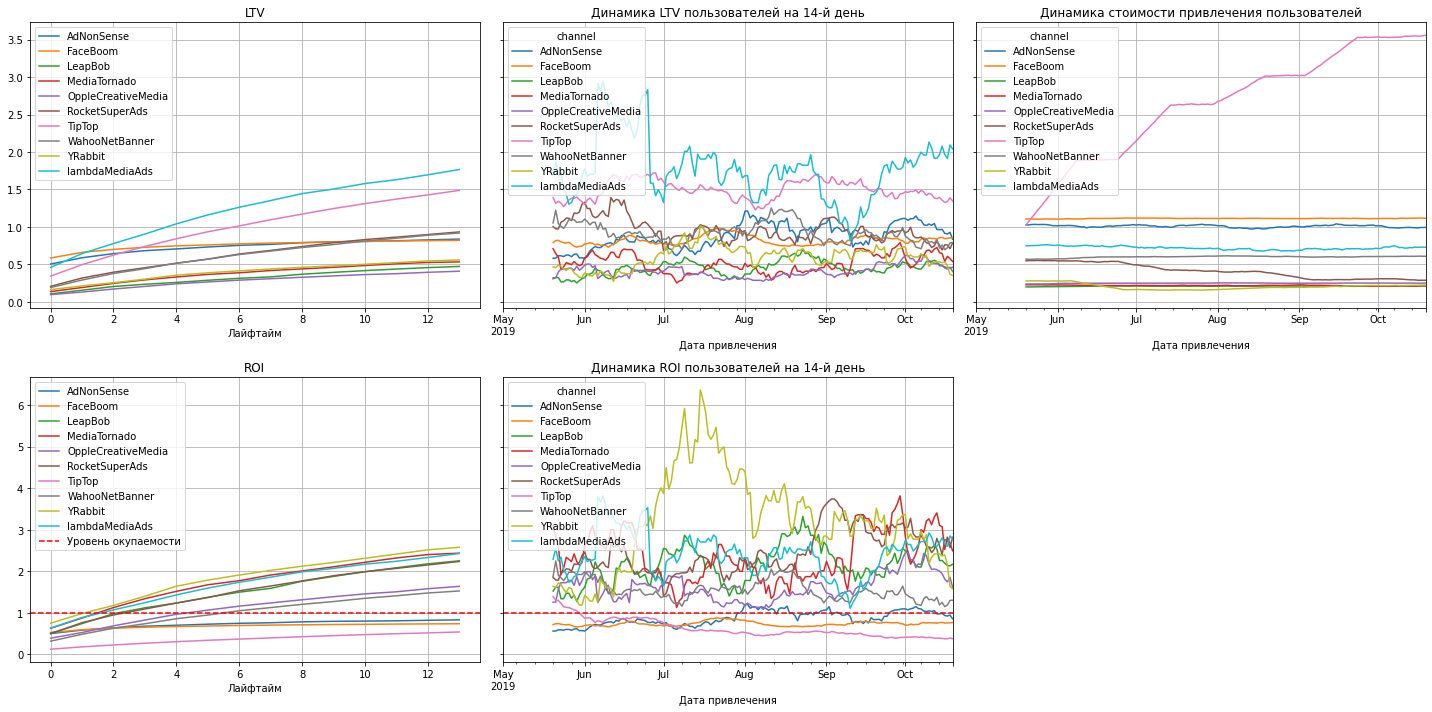

In [41]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=['channel'])
plot_ltv_roi(ltv,ltv_history, roi, roi_history, analysis_horizon, window=20)

<i>Динамика стоимости привлечения пользователей через канал TipTop растет в конце и начале каждого месяца, остальные каналы в течении всего заданного промежутка статичны. Не окупаются пльзователи привлеченные из каналов: AdNonSense, FaceBoom, TipTop. Очень хорошо в процентах окупился на 14-й день канал YRabbit, что можно заметить на соответствующем графике. LTV значитально отличается у каналов TipTop и LamdaMediaAds. <i>

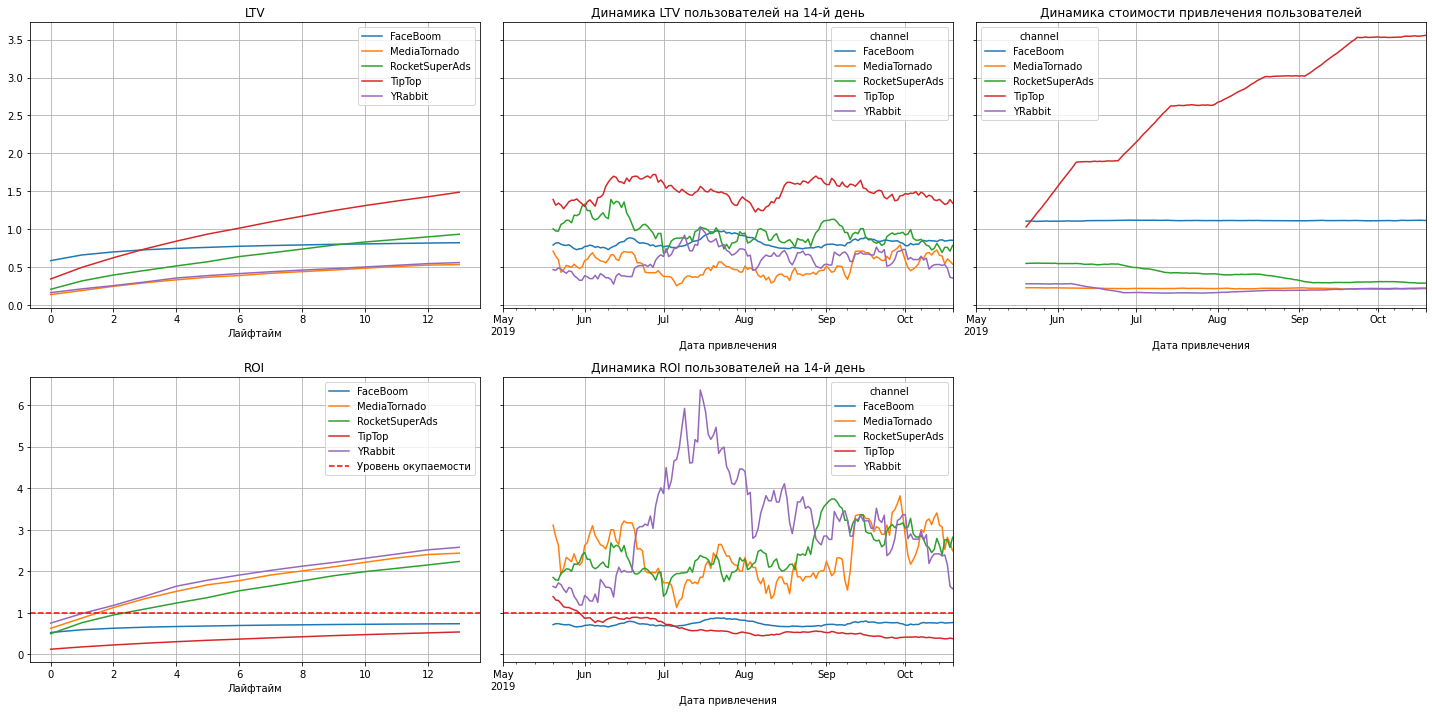

In [42]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('region == "United States"'), orders, observation_date, analysis_horizon, dimensions=['channel'])
plot_ltv_roi(ltv,ltv_history, roi, roi_history, analysis_horizon, window=20)

<i>Если смотреть каналы в срезе только по США, то здесь только 5 каналов привлечения из всех. И окупаемость YRabbit, RocketSuperAds и  MediaTornado происходить между первым и вторым днем. Хорошо себя показывает канал YRabbit и в динамике ROI .<i>

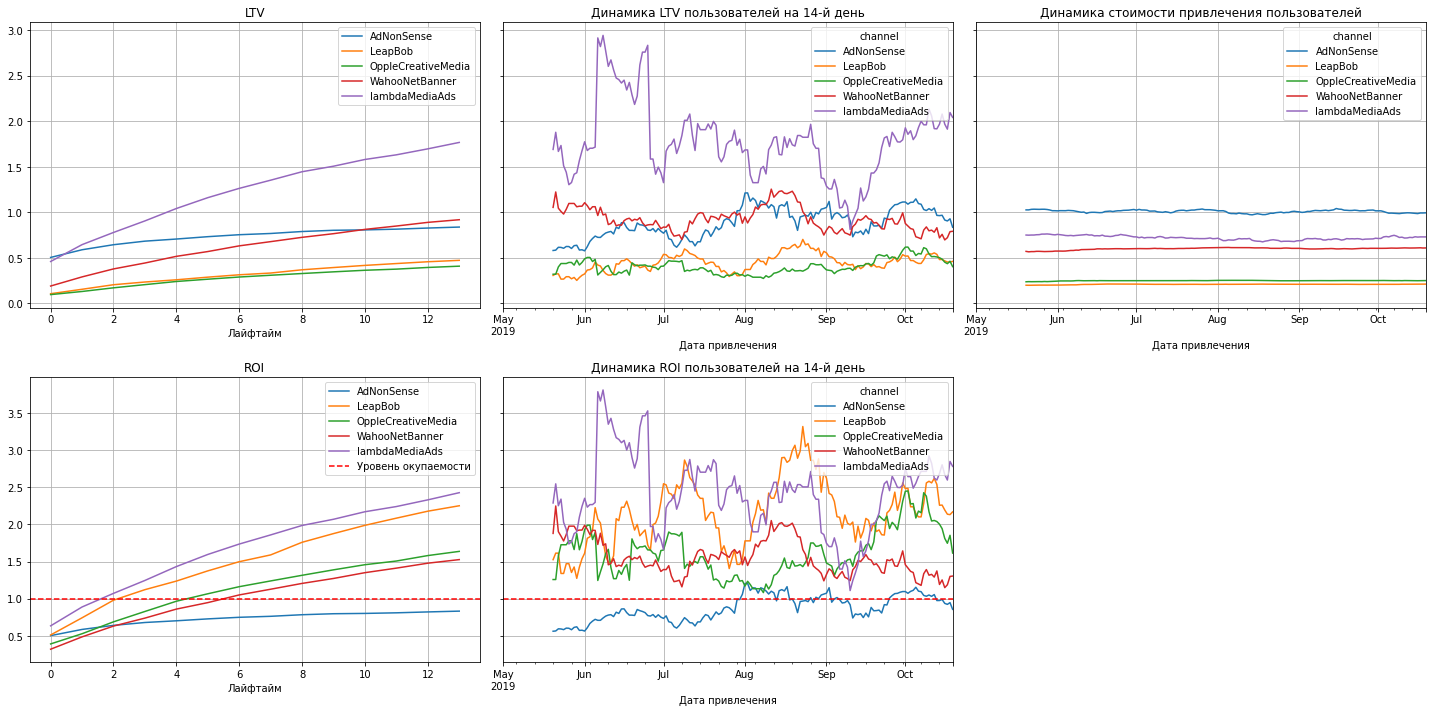

In [43]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('region != "United States"'), orders, observation_date, analysis_horizon, dimensions=['channel'])
plot_ltv_roi(ltv,ltv_history, roi, roi_history, analysis_horizon, window=20)

<i>В срезе стран Европы остальные 5 каналов привлечения из всех. Здесь хорошо себя показывает канал LambdaMediaAds.<i>

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

**Вывод:**<br>
1)При анализе минимальной и максимальной дате привлечения пользователей, можно отметить, высокий рост привлечения к концу месяца и в целом в концу анализируемого периода кол-во зарегистрировавшихся больше. Спад идет на середины месяцев.<br>
2)Большая часть пользователей (совершавших покупки и нет) из США.<br>
3)Большинство пользователей (совершавших покупки и нет) пользуются iphone, остальные почти в равной доли пользуются другими девайсами. Если же говорить о доле платящих пользователей, то здесь преобладает Mac.<br>
4)Больше всего привлечение идет из органического канала, потом только из FaceBoom и TipTop. Больше всего платящих пользователей из каналов FaceBoom, AdNonSense, lambdaMediaAds.<br>
5)Если сравнивать траты на каждый источник с общей суммой трат, можно сделать вывод, что половина всей суммы на рекламу ушла на канал FaceBoom.<br>
6)Везде скачущая динамика изменения расходов во времени по месяцам/неделям, но можно заметить, что TipTop и FaceBoom лидируют, по сравнению с остальными.<br>
7)Самые дорогостоящие пользователи пришли из канала TipTop.
<br>
<br>
<br>
Но при анализе показателей LTV и ROI, графиков динамики LTV, CAC и ROI, конверии и удержании пользователей можно увидеть причину убытков:<br>
Пробелемы из-за тех самых "лидеры" по когортам указанные выше (США, MAC/IPhone, TipTop, FaceBoom). Хоть и конверсия у этих групп пользователей выше, границы окупаемости не достигаются. <br>
<br>
<br>
**Рекомендации для отдела маркетинга:**
Сделать упор на пользователей из Франции, Германии и Англии.<br>
Также поставить в приоритет пользователей на PC и Andriod.<br>
Больше вкладывать в каналы привлечения:  YRabbit в США (быстрая окупаемость и дешевая стоимость привлечения пользователей), LambdaMediaAds в странах Европы (быстрая окупаемость и не сильно меняющаяся стоимость привлечения пользователей.)